# Toy Example 2

#### Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import ticker
from matplotlib.patches import FancyBboxPatch
from pandas import DataFrame, Index, Series
from tabulate import tabulate

from src import metrics
from src.algorithms import lloyd, fairlloyd_gd, faircentroid

In [2]:
plt.rcParams['axes.edgecolor'] = 'grey'
plt.rcParams['axes.linewidth'] = .5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 'small'
plt.rcParams['xtick.major.size'] = plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.pad'] = plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['xtick.color'] = plt.rcParams['ytick.color'] = 'grey'
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['savefig.pad_inches'] = 0
plt.rcParams['savefig.transparent'] = True
plt.rcParams['scatter.marker'] = 'o'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 5
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = True

#### Plotting functions

In [3]:
def plot(X, s, c=None, centroids=None, ax=None, figsize=(75, 75), pad=.03):
    if ax is None:
        mm = 1/25.4
        _, ax = plt.subplots(figsize=(figsize[0]*mm, figsize[1]*mm))
    xmin, xmax = X['x'].aggregate([min, max])
    ymin, ymax = X['y'].aggregate([min, max])
    fpad = 2 * pad * max(xmax-xmin, ymax-ymin)
    _ = ax.set_xlim(0, xmax+fpad)
    _ = ax.set_ylim(0, ymax+fpad)
    if c is not None:
        vertices = X.groupby(c, sort=False).aggregate([min, max])
        cpad = pad * vertices.aggregate(lambda row: max(row[('x', 'max')]-row[('x', 'min')], row[('y', 'max')]-row[('y', 'min')]), axis='columns').max()
        for C, (xmin, xmax, ymin, ymax) in vertices.iterrows():
            width = xmax - xmin + 1.5*cpad
            height = ymax - ymin + 1.5*cpad
            ax.add_patch(FancyBboxPatch((xmin-cpad, ymin-cpad), width, height, boxstyle='round, rounding_size=3', color='gainsboro', alpha=.5))
            _ = ax.annotate(fr"${{C_{C}}}$", (xmin, ymin-2.3*cpad), fontsize=7, ha='right')
    _ = ax.scatter(x=X['x'], y=X['y'], s=5, linewidths=.3, edgecolors=s, facecolors='none', alpha=.4)
    if centroids is not None:
        _ = ax.scatter(x=centroids['x'], y=centroids['y'], s=10, c='black')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.set_aspect('equal')

def plot_combined(X, s, c_lloyd, centroids_lloyd, c_fairlloyd, centroids_fairlloyd, c_faircentroid, centroids_faircentroid, figsize=(75, 75)):
    assert c_fairlloyd.equals(c_lloyd)
    assert c_faircentroid.equals(c_lloyd)
    idxmax = abs(centroids_fairlloyd - centroids_lloyd).idxmax()
    assert abs(centroids_faircentroid - centroids_lloyd).idxmax().equals(idxmax)
    assert idxmax.nunique() == 1
    C_diff = idxmax.unique()[0]
    mm = 1/25.4
    _, ax = plt.subplots(figsize=(figsize[0]*mm, figsize[1]*mm))
    plot(X=X, s=s, c=c_lloyd, ax=ax)
    kwargs = {'s': 15, 'linewidths': .3, 'ec': 'black'}
    for C in centroids_lloyd.index:
        if C == C_diff:
            _ = ax.scatter(x=centroids_lloyd['x'][C], y=centroids_lloyd['y'][C], c='tab:blue', label=r'$k$-means', **kwargs)
            _ = ax.scatter(x=centroids_fairlloyd['x'][C], y=centroids_fairlloyd['y'][C], c='tab:orange', label=r'fair $k$-means', **kwargs)
            _ = ax.scatter(x=centroids_faircentroid['x'][C], y=centroids_faircentroid['y'][C], c='tab:green', label='fair centroids', **kwargs)
        else:
            _ = ax.scatter(x=centroids_lloyd['x'][C], y=centroids_lloyd['y'][C], c='black', **kwargs)
            _ = ax.scatter(x=centroids_fairlloyd['x'][C], y=centroids_fairlloyd['y'][C], c='black', **kwargs)
            _ = ax.scatter(x=centroids_faircentroid['x'][C], y=centroids_faircentroid['y'][C], c='black', **kwargs)
    ax.legend(loc='upper left', fontsize=7, title=fr"${{C_{C_diff}}}$'s centroid", title_fontsize=7)
    ax.figure.savefig('data/toy/toy-2.pdf')

#### Dataset

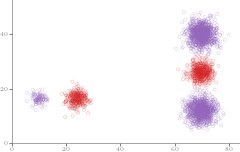

In [4]:
sparsity = .05

r0 = {'mean': [70, 26], 'size': 500}
r0['cov'] = np.sqrt(sparsity * r0['size']) * np.eye(2)

p0a = {'mean': [70, 40], 'size': 1000}
p0a['cov'] = np.sqrt(sparsity * p0a['size']) * np.eye(2)

p0b = {'mean': [70, 12], 'size': 1000}
p0b['cov'] = np.sqrt(sparsity * p0b['size']) * np.eye(2)

r1 = {'mean': [24, 16], 'size': 300}
r1['cov'] = np.sqrt(sparsity * r1['size']) * np.eye(2)

p1 = {'mean': [10, 16], 'size': 100}
p1['cov'] = np.sqrt(sparsity * p1['size']) * np.eye(2)

columns = Index(['x', 'y'], name='attribute')
r0_df = DataFrame(np.random.default_rng(0).multivariate_normal(**r0), columns=columns)
r0_df['color'] = 'tab:red'
p0a_df = DataFrame(np.random.default_rng(1).multivariate_normal(**p0a), columns=columns)
p0a_df['color'] = 'tab:purple'
p0b_df = DataFrame(np.random.default_rng(2).multivariate_normal(**p0b), columns=columns)
p0b_df['color'] = 'tab:purple'

r1_df = DataFrame(np.random.default_rng(3).multivariate_normal(**r1), columns=columns)
r1_df['color'] = 'tab:red'
p1_df = DataFrame(np.random.default_rng(4).multivariate_normal(**p1), columns=columns)
p1_df['color'] = 'tab:purple'

dataset = pd.concat([r0_df, p0a_df, p0b_df, r1_df, p1_df], ignore_index=True)
dataset.index.name = 'object'
X = dataset.drop('color', axis='columns')
s = dataset.filter(['color'], axis='columns').squeeze()
sensitive_groups = list(s.unique())

plot(X, s)

#### Initial configuration

In [5]:
init_c = Series([0]*r0['size'] + [0]*p0a['size'] + [0]*p0b['size'] + [1]*r1['size'] + [1]*p1['size'], name='cluster')
init_centroids = X.groupby(init_c).mean()
init_centroids.index.name = 'cluster'

#### $k$-means

Configuration:
╭─────────────┬──────────────┬────────────┬────────╮
│   algorithm │   n_clusters │   max_iter │    tol │
├─────────────┼──────────────┼────────────┼────────┤
│       Lloyd │            2 │        200 │ 0.0001 │
╰─────────────┴──────────────┴────────────┴────────╯
Initialising centroids
Running algorithm
╭──────┬───────────────┬───────────────┬────────────────╮
│ iter │     objective │ reassignments │ centroid shift │
├──────┼───────────────┼───────────────┼────────────────┤
│    1 │  445882.83187 │          2900 │              - │
│    2 │  445882.83187 │             0 │    0.00000e+00 │
╰──────┴───────────────┴───────────────┴────────────────╯
Converged at iteration 2: strict convergence


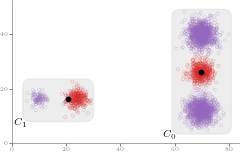

In [6]:
c_lloyd, centroids_lloyd = lloyd.run(n_clusters=2, X=X, init_centroids=init_centroids)
plot(X=X, s=s, c=c_lloyd, centroids=centroids_lloyd)

#### fair $k$-means

Configuration:
╭───────────────────────────────┬──────────────┬────────────┬───────┬───────┬───────┬────────────╮
│                     algorithm │   n_clusters │   max_iter │   tol │   eta │   phi │   patience │
├───────────────────────────────┼──────────────┼────────────┼───────┼───────┼───────┼────────────┤
│ Fair-Lloyd (Gradient Descent) │            2 │        200 │ 1e-07 │ 0.001 │  1000 │         10 │
╰───────────────────────────────┴──────────────┴────────────┴───────┴───────┴───────┴────────────╯
Initialising centroids
Running algorithm
╭──────┬───────────┬───────────────┬────────────────╮
│ iter │ objective │ reassignments │ centroid shift │
├──────┼───────────┼───────────────┼────────────────┤
│    1 │ 207.20188 │          2900 │              - │
│    2 │ 201.90435 │             0 │    1.03109e+01 │
╰──────┴───────────┴───────────────┴────────────────╯
Converged at iteration 2: strict convergence


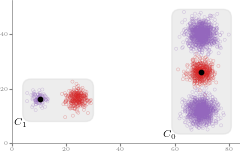

In [7]:
c_fairlloyd, centroids_fairlloyd = fairlloyd_gd.run(n_clusters=2, X=X, s=s, init_centroids=init_centroids, tol=1e-7)
plot(X=X, s=s, c=c_fairlloyd, centroids=centroids_fairlloyd)

#### fair centroids

Configuration:
╭───────────────┬──────────────┬────────────┬───────┬───────┬───────┬────────────┬───────────╮
│     algorithm │   n_clusters │   max_iter │   tol │   eta │   phi │   patience │   lambda_ │
├───────────────┼──────────────┼────────────┼───────┼───────┼───────┼────────────┼───────────┤
│ Fair-Centroid │            2 │        200 │ 1e-07 │ 0.001 │  1000 │         10 │       0.9 │
╰───────────────┴──────────────┴────────────┴───────┴───────┴───────┴────────────┴───────────╯
Initialising centroids
Running algorithm
╭──────┬───────────────┬───────────┬───────────┬───────────────┬────────────────╮
│ iter │       utility |  fairness | objective │ reassignments │ centroid shift │
├──────┼───────────────┼───────────┼───────────┼───────────────┼────────────────┤
│    1 │  445882.83187 │ 327.48954 │ 162.74556 │          2900 │              - │
│    2 │  450524.01340 │ 267.31264 │ 135.82600 │             0 │    3.40628e+00 │
╰──────┴───────────────┴───────────┴───────────┴───────────

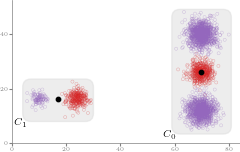

In [8]:
c_faircentroid, centroids_faircentroid = faircentroid.run(n_clusters=2, X=X, s=s, init_centroids=init_centroids, sensitive_groups=sensitive_groups, lambda_=.9, tol=1e-7)
plot(X=X, s=s, c=c_faircentroid, centroids=centroids_faircentroid)

#### Comparison

Evaluating against all metrics
Evaluating against all metrics
Evaluating against all metrics
╭───────────────────────────┬────────────┬────────────────┬──────────────────╮
│ metric                    │    k-means │   fair k-means │   fair centroids │
├───────────────────────────┼────────────┼────────────────┼──────────────────┤
│ average cluster disparity │   0.982064 │       0.963926 │         0.459182 │
│ k-means objective         │ 153.753    │     168.417    │       155.353    │
│ fair centroid objective   │ 163.745    │     205.293    │       133.656    │
│ fair k-means objective    │ 207.202    │     201.904    │       204.332    │
╰───────────────────────────┴────────────┴────────────────┴──────────────────╯


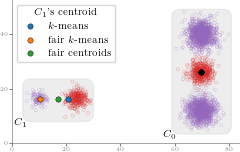

In [9]:
kwargs = {'X': X, 's': s, 'display': False}
scores = pd.concat(
    {'k-means': metrics.evaluate(c=c_lloyd, centroids=centroids_lloyd, **kwargs),
     'fair k-means': metrics.evaluate(c=c_fairlloyd, centroids=centroids_fairlloyd, **kwargs),
     'fair centroids': metrics.evaluate(c=c_faircentroid, centroids=centroids_faircentroid, **kwargs)
     },
    names=['objectives']
    )
print(tabulate(scores.unstack(level='objectives'), headers='keys', tablefmt='rounded_outline'))
plot_combined(X=X, s=s, c_lloyd=c_lloyd, centroids_lloyd=centroids_lloyd, c_fairlloyd=c_fairlloyd, centroids_fairlloyd=centroids_fairlloyd, c_faircentroid=c_faircentroid, centroids_faircentroid=centroids_faircentroid)